# Bilderkennung mit neuronalen Netzen
In dieser Session wollen wir ein neuronales Netz zur Klassifikation von Bildern bauen. Dazu verwenden wir die Bibliotheken TensorFlow 2 und Keras (High Level API).

Wir verwenden die zumn Testen von neuronalen Netzen weit verbreiteten *Fashon MNIST* Daten. Diese bestehen aus 70.000 Bildern mit jeweils 28x28 Pixeln (Graustufen). Die Bilder zeigen dabei Objekte aus 10 verscheidenen Klassen, allesamt Kleidungsstücke.

**Ziel:** Entwerfe und trainiere ein neuronales Netz, das Bilder von Gegenständen dieser 10 Kategorien korrekt einordnen kann.

Zu allererst importieren wir die benötigten Bibliotheken:

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.__version__

TensorFlow 2.x selected.


'2.1.0-rc1'

## 1. Vorbereitung der Daten
Da dieser Datensatz eine wichtige Rolle beim Testen von neuronalen Netzen spielt, ist er bereits in Keras enthalten und muss nur noch geladen werden. Eine Aufteilung des gesamten Datensatzes in Trainingsdaten und Testdaten findet hier ebenfalls bereits durch das Laden der Daten statt:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full.shape

(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

Jedes der Bilder wird also durch ein 28x28 Array dargestellt. Für jeden Pixel wird der Grauwert durch eine Zahle zwischen 0 und 255 angegeben.

In [ ]:
X_train_full[100][20][16]

210

Typischerweise sollte man die Daten skalieren. Neuronale Netze "mögen" es, wenn die Daten Mittelwert 0 und Standardabweichung 1 haben.

Wichtig: Wenn man skaliert, müssen auch die Testdaten skaliert werden.

Es sind zwar bereits Testdaten vorhanden, diese dürfen wir aber im Zuge der Erstellung des Modells **gar nicht** verwenden. Sie dürfen nur verwendet werden, um die Performance des **fertigen Modells** zu testen.

Um während der Erstellung dennoch Testen zu können, verwenden wir sog. Validierungsdaten. Diese entnehmen wir den Trainingsdaten. Für den vorliegenden Fall verwenden wir zur Validierung z.B. die ersten 5000 Bilder. Die restlichen Bilder bilden das Trainingsset.

In [ ]:
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]

In [ ]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

In [ ]:
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

Die Daten entsprechen Bildinformationen und somit bietet es sich an, sich diese entsprechend darstellen zu lassen. Hier das erste Bild der Trainingsdaten ``X_train[0]``:

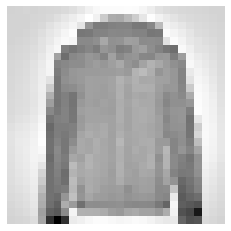

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Als nächstes betrachten wir die zu unterscheidenden Klassen.

In [ ]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Hier stehen nur die Ziffern 0-9. Welche Ziffer welchem Kleidungsstück entspricht, ist in den Daten nicht mit angegeben. 4 scheint aber einer Jacke zu entsprechen. Aus der Dokumentation der Daten lernen wir:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Für die oben abgeildete Jacke ``X_train[0]`` erhalten wir:

In [ ]:
class_names[y_train[0]]

'Coat'

Betrachten wir nun einen Ausschnitt der Trainingsdaten inkl. Labels:

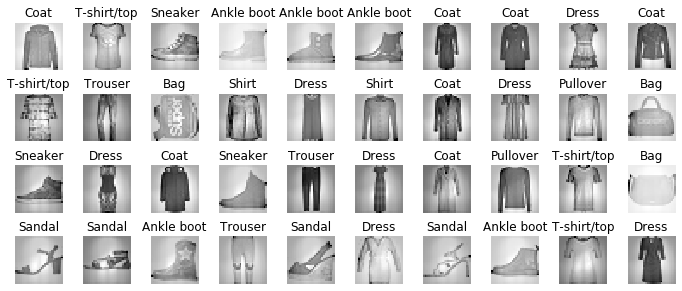

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## 2. Erstellen des Modells
Wir wollen ein MLP mit zwei Hidden Layers erstellen:


1.   Input Layer: Jedes Input-Datum ist ein Bild, konkret ist es das oben genannte 28x28 Array.
2.   Das erste Hidden Layer soll 300 Neuronen haben und ReLU als Aktivierungsfunktion verwenden.
3. Das zweite Hidden Layer soll 100 Neuronen haben und ebenfalls ReLU als Aktivierungsfunktion verwenden.
4. Das Output Layer muss dann die Informationen bereitstellen, welcher Klasse der aktuelle Input zuzuordnen ist.

Zu allererst erzeugen wir ein Modell. Da wir ein einfaches Feedforward Netz wollen, verwenden wir hierzu ``keras.models.Sequential()``:



In [ ]:
model = keras.models.Sequential()

Nun zum Input Layer: Da wir als Input einen Vektor benötigen, müssen wir das 28x28 Array in einen 28*28= 784 dimensionalen Vektor umwandeln. Das geschieht durch

In [ ]:
model.add(keras.layers.Flatten(input_shape=[28, 28]))

Als nächstes werden die beiden Hidden Layer hinzugefügt. Diese sind ``Dense`` Layers, denn jedes Neuron ist mit jedem Input verbunden. Außerdem kümmert sich ein ``Dense`` Layer selbst um die entsprechende Matrix der Gewichte und um die Bias-Terme. Dies geschieht durch

In [ ]:
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))

Nun kommt die Output Schicht. Diese soll aus 10 Neuronen bestehen, da wir 10 Klassen haben. Als Aktivierungsfunktion verwenden wir hier ``softmax``. Der Output des ersten Neurons ist dann als Wahrscheinlichkeit zu interpretieren, dass es sich um Klasse 1 handelt; der Output von Neuron 2 analog als die Wahrscheinlichkeit für Klasse 2, ...

In [ ]:
model.add(keras.layers.Dense(10, activation="softmax"))

Durch ``model.summary()`` können wir uns einen Überblick verschaffen:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Das erste Layer hat also als Parameter alle Gewicht, die 784 Inputs mit 300 Neuronen verbinden, zuzüglich eines Bias Parameters pro Neuron: 784*300+300=235500.

Solche ein Modell hat also einiges an Flexibilität, birgt aber die *massive* Gefahr eines Overfittings.

Auf die einzelnen Gewichte haben wir Zugriff mittels ``get_weights()``, also etwa

In [ ]:
weights, biases = model.layers[1].get_weights()

In [ ]:
weights

array([[ 0.0541836 , -0.05317236, -0.04750109, ..., -0.03913033,
        -0.04423333, -0.05911253],
       [ 0.0363576 , -0.07111074,  0.05523948, ...,  0.0262924 ,
         0.02834547, -0.02655602],
       [ 0.05136406,  0.0545942 , -0.00076167, ..., -0.02238373,
        -0.02079041,  0.06823631],
       ...,
       [ 0.03768983, -0.03765631,  0.00622368, ...,  0.02105842,
         0.00564622, -0.05938569],
       [-0.04295308,  0.01392035, -0.02061921, ..., -0.04645466,
        -0.00084179,  0.07145126],
       [ 0.00122975, -0.02815959, -0.03411239, ..., -0.0178677 ,
         0.04845276,  0.04214136]], dtype=float32)

Die Gewichte scheinen zufällig initialisiert worden zu sein (wichtig, um die Symmetrie zu brechen).

In [ ]:
weights.shape

(784, 300)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
biases.shape

(300,)

## 3. Compilieren des Modells
Somit haben wir also die "Form" des neuronalen Netzes und seine Aktivierungsfunktionen definiert. Um ein Modell anzugeben, müssen noch zwei Dinge angegeben werden:

1.  Loss Funktion
2. Optimierungsmehtode

Als Loss Funktion wollen wir ``sparse_categorical_crossentropy`` verwenden, als Optimizer verwenden wir *Stochastic Gradient Descent*. ``sparse_categorical_crossentropy``  verwenden wir, da wir kategorische Daten vorliegen haben und wir für jedes Bild nur *eine* Zahl als Ziel haben. Die Optimierungsmethode gibt an, wie mit Kenntnis des Gradienten der Loss Funktion (ermittelt durch Backpropagation) ein Optimum gefunden werden soll.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Das zusätzliche Argument ``metrics=["accuracy"]`` haben wir übergeben, damit beim Training und auch der Auswertung die Genauigkeit mit gemessen wird (rein informativ).

Nun muss das Modell nur noch trainiert werden. Dafür übergeben wir der ``.fit()`` Methode die Trainingsdaten ``X_train`` mit den zugehörigen Labels ``y_train``. Das Modell soll 30 Epochen lang trainiert werden (d.h. es wird jedes der 45000 Trainingsbilder 30 mal sehen). Außerdem soll direkt eine Validierung mit durchgeführt werden. D.h. der Loss und die Genauigkeit ("Accuracy") werden nicht nur auf den Trainingsdaten, sondern auch auf den Validierungsdaten berechnet. Daran können wir ggf. Overfitting bemerken (wenn die Werte auf den Trainingsdaten wesentlich besser sind als auf den Validierungsdaten).

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.5228 - accuracy: 0.8175 - val_loss: 0.3973 - val_accuracy: 0.8614
Epoch 2/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3672 - accuracy: 0.8686 - val_loss: 0.3775 - val_accuracy: 0.8678
Epoch 3/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3267 - accuracy: 0.8844 - val_loss: 0.3501 - val_accuracy: 0.8772
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2994 - accuracy: 0.8925 - val_loss: 0.3386 - val_accuracy: 0.8816
Epoch 5/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2771 - accuracy: 0.9007 - val_loss: 0.3299 - val_accuracy: 0.8822
Epoch 6/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2599 - accuracy: 0.9060 - val_loss: 0.3213 - val_accuracy: 0.8848
Epoch 7/10
55000/55000 [==============================] 

Die Genauigkeit ist mit ca. 92% auf den Trainingsdaten und 89% auf den Testdaten gut und auch vergleichbar groß, d.h. es liegt wohl kein (starkes) Overfitting vor.

Das oben angelegt ``History`` Objekt enthält die Trainingsparameter (``history.params``) und die während dem Training gesammelten Daten. 

In [ ]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 10,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy'],
 'samples': 55000,
 'steps': 1719,
 'verbose': 0}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Diese Informationen fassen wir in einem DataFrame zusammen:

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.522762,0.817509,0.397295,0.8614
1,0.367177,0.868582,0.377507,0.8678
2,0.326706,0.884400,0.350092,0.8772
3,0.299368,0.892545,0.338590,0.8816
4,0.277062,0.900745,0.329949,0.8822
5,0.259877,0.906018,0.321339,0.8848
6,0.244110,0.912436,0.323965,0.8876
7,0.229934,0.915909,0.320693,0.8880
8,0.218387,0.921018,0.317324,0.8896
9,0.206174,0.926618,0.324256,0.8888


Das können wir gut plotten:

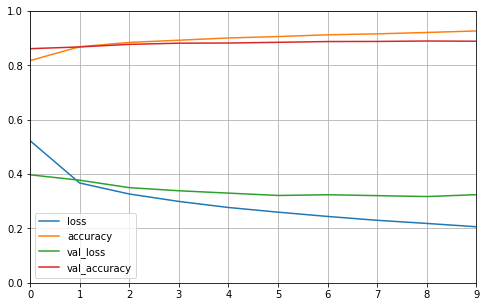

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Wenn wir mit dem Modell soweit zufrieden sind - **und erst dann** - können wir es auf den Testdaten evaluieren:

In [ ]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 57us/sample - loss: 0.3472 - accuracy: 0.8795


[0.34721709827184677, 0.8795]

# 4. Anwenden des Modells
Dieses nun fertig trainierte Modell können wir nun verwenden, um neue Daten (hier: Bilder) zu klassifizieren. Dafür verwenden wir die ``predict()`` Methode. Diese Wenden wir z.B. auf folgende drei Bilder aus dem Testset an (die hat das Modell noch nie gesehen).

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

Das Ergebnis sind wie wir wollten die Wahrscheinlichkeiten, dass das fragliche Objekt in Kategorie 0, ..., 9 gehört. Natürlich können wir uns auch nur die jeweils wahrscheinlichste Klasse zurückgeben lassen (das wäre die Antwort des Modells):

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

Da die drei Bilder aus den Testdaten sind, können wir auch die korrekten Antworten nachschauen:

In [ ]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Stimmt also. Konkret wären das:

In [ ]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Oder als Bild:

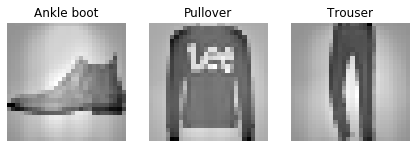

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# 5. Alternative Modelle

## Underfitting

In [ ]:
model_uf = keras.models.Sequential()
model_uf.add(keras.layers.Flatten(input_shape=[28,28]))
model_uf.add(keras.layers.Dense(20, activation="relu"))
model_uf.add(keras.layers.Dense(10, activation="softmax"))
model_uf.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
model_uf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                15700     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


Noch ist das Modell nicht trainiert, d.h. wir erwarten ca. 10% Genauigkeit.

In [ ]:
model_uf.evaluate(X_valid, y_valid)

5000/5000 [==============================] - 0s 71us/sample - loss: 2.9417 - accuracy: 0.1088


[2.941668127822876, 0.1088]

In [ ]:
history_uf = model_uf.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.5935 - accuracy: 0.7965 - val_loss: 0.4423 - val_accuracy: 0.8460
Epoch 2/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.4273 - accuracy: 0.8470 - val_loss: 0.4117 - val_accuracy: 0.8578
Epoch 3/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3956 - accuracy: 0.8590 - val_loss: 0.3937 - val_accuracy: 0.8622
Epoch 4/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3757 - accuracy: 0.8658 - val_loss: 0.3823 - val_accuracy: 0.8670
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3620 - accuracy: 0.8708 - val_loss: 0.3800 - val_accuracy: 0.8664
Epoch 6/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3516 - accuracy: 0.8740 - val_loss: 0.3714 - val_accuracy: 0.8664
Epoch 7/10
55000/55000 [==============================] -

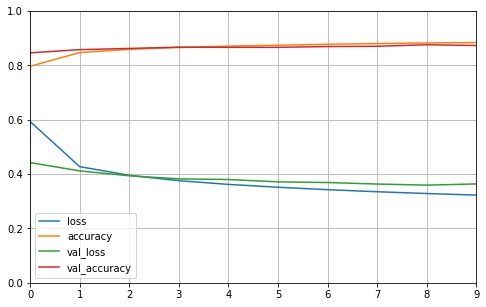

In [ ]:
pd.DataFrame(history_uf.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_uf.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 57us/sample - loss: 0.4028 - accuracy: 0.8595


[0.4027891322135925, 0.8595]

## Overfitting

In [ ]:
model_of = keras.models.Sequential()
model_of.add(keras.layers.Flatten(input_shape=[28,28]))
model_of.add(keras.layers.Dense(500, activation="relu"))
model_of.add(keras.layers.Dense(400, activation="relu"))
model_of.add(keras.layers.Dense(200, activation="relu"))
model_of.add(keras.layers.Dense(100, activation="relu"))
model_of.add(keras.layers.Dense(10, activation="softmax"))
model_of.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
model_of.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_13 (Dense)             (None, 400)               200400    
_________________________________________________________________
dense_14 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1010      
Total params: 694,210
Trainable params: 694,210
Non-trainable params: 0
________________________________________________

In [ ]:
history_of = model_of.fit(X_train[:5000], y_train[:5000], epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 1s 202us/sample - loss: 1.1761 - accuracy: 0.6380 - val_loss: 0.7302 - val_accuracy: 0.7360
Epoch 2/10
5000/5000 [==============================] - 1s 141us/sample - loss: 0.6236 - accuracy: 0.7872 - val_loss: 0.6415 - val_accuracy: 0.7648
Epoch 3/10
5000/5000 [==============================] - 1s 140us/sample - loss: 0.5054 - accuracy: 0.8300 - val_loss: 0.5071 - val_accuracy: 0.8198
Epoch 4/10
5000/5000 [==============================] - 1s 135us/sample - loss: 0.4314 - accuracy: 0.8486 - val_loss: 0.4978 - val_accuracy: 0.8248
Epoch 5/10
5000/5000 [==============================] - 1s 137us/sample - loss: 0.3779 - accuracy: 0.8710 - val_loss: 0.4825 - val_accuracy: 0.8286
Epoch 6/10
5000/5000 [==============================] - 1s 139us/sample - loss: 0.3421 - accuracy: 0.8780 - val_loss: 0.4494 - val_accuracy: 0.8350
Epoch 7/10
5000/5000 [==============================] - 1s 141us

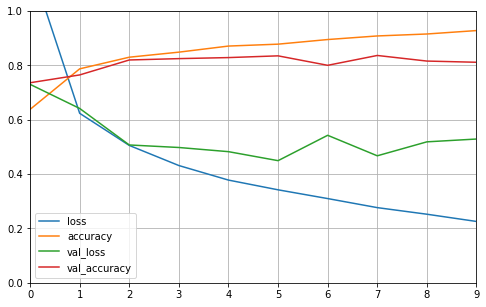

In [ ]:
pd.DataFrame(history_of.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_of.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 57us/sample - loss: 0.5788 - accuracy: 0.8027


[0.5787832374095917, 0.8027]

## Convolutional Neural Networks (CNNs)
Einen sehr guten Einstieg in CNNs finden Sie [hier](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks).

In [ ]:
X_train.shape

(55000, 28, 28)

In [ ]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_train.shape

(55000, 28, 28, 1)

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [ ]:
history_cnn = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 44s 801us/sample - loss: 0.6886 - accuracy: 0.7623 - val_loss: 0.3595 - val_accuracy: 0.8670
Epoch 2/10
55000/55000 [==============================] - 36s 657us/sample - loss: 0.4100 - accuracy: 0.8631 - val_loss: 0.2929 - val_accuracy: 0.8926
Epoch 3/10
55000/55000 [==============================] - 36s 656us/sample - loss: 0.3493 - accuracy: 0.8843 - val_loss: 0.3069 - val_accuracy: 0.8912
Epoch 4/10
55000/55000 [==============================] - 36s 657us/sample - loss: 0.3247 - accuracy: 0.8905 - val_loss: 0.2822 - val_accuracy: 0.8976
Epoch 5/10
55000/55000 [==============================] - 36s 656us/sample - loss: 0.2926 - accuracy: 0.9001 - val_loss: 0.3015 - val_accuracy: 0.8926
Epoch 6/10
55000/55000 [==============================] - 36s 658us/sample - loss: 0.2848 - accuracy: 0.9032 - val_loss: 0.2715 - val_accuracy: 0.9034
Epoch 7/10
55000/55000 [=====================

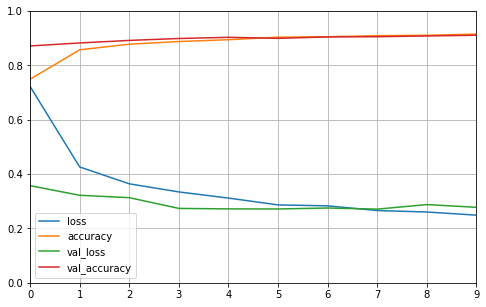

In [ ]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 94us/sample - loss: 0.2969 - accuracy: 0.9067


[0.29690737375617027, 0.9067]

# 6. Komplexere Bilddaten
[CNN auf dem CIFAR10 Datensatz](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb)